In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd

from datetime import datetime

from pyrap.quanta import quantity
from pyrap.measures import measures

from sourcefinder.accessors import open as open_accessor
from sourcefinder.accessors import sourcefinder_image_from_accessor

import astropy.io.fits as fits
from astropy.io.fits.hdu.hdulist import HDUList
from astropy.time import Time
from astropy import units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord,match_coordinates_sky,search_around_sky


import pytz
import pylab
import math
import numpy
import sys
import pyfits
import os
import time
import pickle
import glob

import operator

from scipy.signal import convolve2d
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.optimize import leastsq

from matplotlib.ticker import NullFormatter
from matplotlib.font_manager import FontProperties
import matplotlib.axes as axes
import matplotlib

pylab.rcParams['legend.loc'] = 'best'
matplotlib.use('Agg')

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/trait

In [2]:
aart = pd.read_csv("/home/kuiack/AARTFAAC_catalogue.csv")
ateam = {"ra":np.array([82.88,299.43,350.28,187.07]),"decl":np.array([21.98,40.59,58.54,12.66])}

In [3]:
image_list = sorted(glob.glob("/data/AS_201810210800/*.fits"))

In [4]:
def aperture_pixels(data,x,y,r,meshx,meshy):
    '''Return data (2D array) values which fall within a pixel distance r, of x and y locations. Meshgrids required to 
    number pixels.'''
    return data[np.where(np.sqrt((meshx-x)**2+(meshy-y)**2.) <= r)]

def aperture_bool(x,y,r,meshx,meshy):
    '''Return bool array (2D array) values which fall within a pixel distance r, of x and y locations. Meshgrids required to 
    number pixels.'''
    return (np.sqrt((meshx-x)**2+(meshy-y)**2.) <= r)



In [5]:
# def get_configuration():
#     """
#     Returns a populated configuration
#     """
#     parser = argparse.ArgumentParser()

#     parser.add_argument('--indir', type=str, default="/tmp",
#                         help="Input directory for fitsfile.")
#     parser.add_argument('--fitsfile', type=str, default="./",
#                         help="Target fits file.")

#     parser.add_argument('--threshold', type=float, default=5.0,
#                         help="RMS Threshold to reject image.")
#     parser.add_argument('--outdir', type=str, default="./",
#                         help="Desitnation directory.")

#     parser.add_argument("--detection", default=10, type=float,
#                             help="Detection threshold")
#     parser.add_argument("--analysis", default=3, type=float,
#                             help="Analysis threshold")

#     parser.add_argument("--radius", default=0, type=float,
#                             help="Radius of usable portion of image (in pixels)")
#     parser.add_argument("--grid", default=64, type=float,
#                             help="Background grid segment size")

#     parser.add_argument("--reference", default="", type=str,
#                             help="Path of reference catalogue used for flux fitting. ")

#     return parser.parse_args()

# cfg = get_configuration()
def distSquared(p0, p1):
    '''
    Calculate the distance between point p0, [x,y], and a list of points p1, [[x0..xn],[y0..yn]]. 
    '''
    distance  = np.sqrt((p0[0] - p1[0,:])**2 + (p0[1] - p1[1,:])**2)
    if np.min(distance) < 1.0:
        return np.where(distance == np.min(distance))[0]
    else:
        return None

def pol2cart(rho, phi):
    """
    Polar to Cartesian coordinate conversion, for distance measure around celestial pole.
    """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def compare_flux(sr, catalog_ras, catalog_decs, catalog_fluxs, catalog_flux_errs):
    '''
    Compares the two catalogues, matching sources, and outputs the results of linear fit to the fluxes. 
    '''
    x = []
    y = []

    w = []
    sr_indexes = []
    cat_indexes = []


    for i in range(len(sr)):

        sr_x, sr_y = pol2cart(np.abs(90-sr[i].dec.value),
                np.deg2rad(sr[i].ra.value))

        cat_x, cat_y = pol2cart(np.abs(90-catalog_decs),
                np.deg2rad(catalog_ras))

        index = distSquared((sr_x,sr_y),
                   np.array([cat_x, cat_y]))

        if type(index) == np.ndarray:
            flux = catalog_fluxs[index]
            flux_err = catalog_flux_errs[index]

            cat_indexes.append(index)
            sr_indexes.append(i)
            y.append(float(sr[i].flux))
            x.append(float(flux))
            w.append(float(sr[i].flux.error))
        else:
            continue
            
    if len(x) > 2:
        w = np.array(w,dtype=float)
        fit = np.polyfit(x,y,1,w=1./w)
    else:
        fit = [1e9,1e9]

    return fit[0], fit[1]


def process(image_file):
    '''
    Perform an initial quality control filtering step on the incoming image stream. Images
    which are not rejected are then flux calibrated using a reference catalogue.
    '''
    
    print "running process"

    lofarfrequencyOffset = 0.0
    lofarBW = 195312.5
    
    ref_cat = pd.read_csv("/home/kuiack/AARTFAAC_catalogue.csv")
    
    fitsimg = fits.open(image_file)[0]
    
    t = Time(fitsimg.header['DATE-OBS'])
    frq = fitsimg.header['RESTFRQ']
    bw = fitsimg.header['RESTBW']


    # Initial quality condition. 
    if np.nanstd(fitsimg.data[0,0,:,:]) < 1e4:

        # Source find 
        configuration = {
            "back_size_x": 64,
            "back_size_y": 64,
            "margin": 0,
            "radius": 400}

        img_HDU = fits.HDUList(fitsimg)
        imagedata = sourcefinder_image_from_accessor(open_accessor(fits.HDUList(fitsimg),
                                                                   plane=0),
                                                     **configuration)

        sr = imagedata.extract(det=5.0, anl=3.0,
                               labelled_data=None, labels=[],
                               force_beam=True)

        # Reference catalogue compare
        slope_cor, intercept_cor = compare_flux(sr,
                                       ref_cat["ra"],
                                       ref_cat["decl"],
                                       ref_cat["f_int"],
                                       ref_cat["f_int_err"])

        
  
        fields=[slope_cor, intercept_cor, len(sr)]
#         with open(r'/home/kuiack/fit_results.csv', 'a') as f:
#             writer = csv.writer(f)
#             writer.writerow(fields)


        # Slope set to 1e9 if line fit fails
        if slope_cor < 1e8:
            return slope_cor, intercept_cor
#             filename = '%s.fits' % (datetime.fromtimestamp(t.unix).strftime('%Y-%m-%dT%H:%M:%S')+ \
#                             "-S"+str(round((frq-lofarfrequencyOffset)/lofarBW,1))+ \
#                             "-B"+str(int(np.ceil(bw /lofarBW))))

#             fitsimg.data[0,0,:,:] = (fitsimg.data[0,0,:,:]-intercept_cor)/slope_cor
#             fitsimg.writeto(cfg.outdir+filename,overwrite=True)
#             os.remove(cfg.indir+cfg.fitsfile)
        else:
            print "bad fit"
            np.nan, np.nan
            return
    else:
        print "bad image"
        return np.nan, np.nan

In [6]:
def rolling_window(array, window=(0,), asteps=None, wsteps=None, axes=None, toend=True):
    """Create a view of `array` which for every point gives the n-dimensional
    neighbourhood of size window. New dimensions are added at the end of
    `array` or after the corresponding original dimension.
    
    Parameters
    ----------
    array : array_like
        Array to which the rolling window is applied.
    window : int or tuple
        Either a single integer to create a window of only the last axis or a
        tuple to create it for the last len(window) axes. 0 can be used as a
        to ignore a dimension in the window.
    asteps : tuple
        Aligned at the last axis, new steps for the original array, ie. for
        creation of non-overlapping windows. (Equivalent to slicing result)
    wsteps : int or tuple (same size as window)
        steps for the added window dimensions. These can be 0 to repeat values
        along the axis.
    axes: int or tuple
        If given, must have the same size as window. In this case window is
        interpreted as the size in the dimension given by axes. IE. a window
        of (2, 1) is equivalent to window=2 and axis=-2.       
    toend : bool
        If False, the new dimensions are right after the corresponding original
        dimension, instead of at the end of the array. Adding the new axes at the
        end makes it easier to get the neighborhood, however toend=False will give
        a more intuitive result if you view the whole array.
    
    Returns
    -------
    A view on `array` which is smaller to fit the windows and has windows added
    dimensions (0s not counting), ie. every point of `array` is an array of size
    window.
    
    Examples
    --------
    >>> a = np.arange(9).reshape(3,3)
    >>> rolling_window(a, (2,2))
    array([[[[0, 1],
             [3, 4]],
            [[1, 2],
             [4, 5]]],
           [[[3, 4],
             [6, 7]],
            [[4, 5],
             [7, 8]]]])
    
    Or to create non-overlapping windows, but only along the first dimension:
    >>> rolling_window(a, (2,0), asteps=(2,1))
    array([[[0, 3],
            [1, 4],
            [2, 5]]])
    
    Note that the 0 is discared, so that the output dimension is 3:
    >>> rolling_window(a, (2,0), asteps=(2,1)).shape
    (1, 3, 2)
    
    This is useful for example to calculate the maximum in all (overlapping)
    2x2 submatrixes:
    >>> rolling_window(a, (2,2)).max((2,3))
    array([[4, 5],
           [7, 8]])
           
    Or delay embedding (3D embedding with delay 2):
    >>> x = np.arange(10)
    >>> rolling_window(x, 3, wsteps=2)
    array([[0, 2, 4],
           [1, 3, 5],
           [2, 4, 6],
           [3, 5, 7],
           [4, 6, 8],
           [5, 7, 9]])
    """
    array = np.asarray(array)
    orig_shape = np.asarray(array.shape)
    window = np.atleast_1d(window).astype(int) # maybe crude to cast to int...
    
    if axes is not None:
        axes = np.atleast_1d(axes)
        w = np.zeros(array.ndim, dtype=int)
        for axis, size in zip(axes, window):
            w[axis] = size
        window = w
    
    # Check if window is legal:
    if window.ndim > 1:
        raise ValueError("`window` must be one-dimensional.")
    if np.any(window < 0):
        raise ValueError("All elements of `window` must be larger then 1.")
    if len(array.shape) < len(window):
        raise ValueError("`window` length must be less or equal `array` dimension.") 

    _asteps = np.ones_like(orig_shape)
    if asteps is not None:
        asteps = np.atleast_1d(asteps)
        if asteps.ndim != 1:
            raise ValueError("`asteps` must be either a scalar or one dimensional.")
        if len(asteps) > array.ndim:
            raise ValueError("`asteps` cannot be longer then the `array` dimension.")
        # does not enforce alignment, so that steps can be same as window too.
        _asteps[-len(asteps):] = asteps
        
        if np.any(asteps < 1):
             raise ValueError("All elements of `asteps` must be larger then 1.")
    asteps = _asteps
    
    _wsteps = np.ones_like(window)
    if wsteps is not None:
        wsteps = np.atleast_1d(wsteps)
        if wsteps.shape != window.shape:
            raise ValueError("`wsteps` must have the same shape as `window`.")
        if np.any(wsteps < 0):
             raise ValueError("All elements of `wsteps` must be larger then 0.")

        _wsteps[:] = wsteps
        _wsteps[window == 0] = 1 # make sure that steps are 1 for non-existing dims.
    wsteps = _wsteps

    # Check that the window would not be larger then the original:
    if np.any(orig_shape[-len(window):] < window * wsteps):
        raise ValueError("`window` * `wsteps` larger then `array` in at least one dimension.")

    new_shape = orig_shape # just renaming...
    
    # For calculating the new shape 0s must act like 1s:
    _window = window.copy()
    _window[_window==0] = 1
    
    new_shape[-len(window):] += wsteps - _window * wsteps
    new_shape = (new_shape + asteps - 1) // asteps
    # make sure the new_shape is at least 1 in any "old" dimension (ie. steps
    # is (too) large, but we do not care.
    new_shape[new_shape < 1] = 1
    shape = new_shape
    
    strides = np.asarray(array.strides)
    strides *= asteps
    new_strides = array.strides[-len(window):] * wsteps
    
    # The full new shape and strides:
    if toend:
        new_shape = np.concatenate((shape, window))
        new_strides = np.concatenate((strides, new_strides))
    else:
        _ = np.zeros_like(shape)
        _[-len(window):] = window
        _window = _.copy()
        _[-len(window):] = new_strides
        _new_strides = _
        
        new_shape = np.zeros(len(shape)*2, dtype=int)
        new_strides = np.zeros(len(shape)*2, dtype=int)
        
        new_shape[::2] = shape
        new_strides[::2] = strides
        new_shape[1::2] = _window
        new_strides[1::2] = _new_strides
    
    new_strides = new_strides[new_shape != 0]
    new_shape = new_shape[new_shape != 0]
    
    return np.lib.stride_tricks.as_strided(array, shape=new_shape, strides=new_strides)

In [7]:


meshx, meshy = np.meshgrid(np.linspace(0,1023,1024),np.linspace(0,1023,1024))


wcs = WCS(image_list[0])

c_x, c_y, n, nn =wcs.wcs_world2pix(10,90,1,1,1)

app_x = np.array(aperture_pixels(meshx,c_x, c_y,100,meshx,meshy), dtype=int)
app_y = np.array(aperture_pixels(meshy,c_x, c_y,100,meshx,meshy), dtype=int)

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

In [177]:
for i in range(len(ateam["ra"])):

    c_y, c_x, n, nn =wcs.wcs_world2pix(ateam["ra"][i],ateam["decl"][i],1,1,1)
    print c_x, c_y

nan nan
403.777310633 504.851061988
645.261875099 302.286089224
nan nan


In [33]:
image_list

['/data/AS_201810210800/2018-10-21T08:00:10-S314-B8.fits',
 '/data/AS_201810210800/2018-10-21T08:00:11-S314-B8.fits',
 '/data/AS_201810210800/2018-10-21T08:00:12-S314-B8.fits',
 '/data/AS_201810210800/2018-10-21T08:00:13-S314-B8.fits',
 '/data/AS_201810210800/2018-10-21T08:00:14-S296-B8.fits',
 '/data/AS_201810210800/2018-10-21T08:00:14-S314-B8.fits',
 '/data/AS_201810210800/2018-10-21T08:00:15-S296-B7.fits',
 '/data/AS_201810210800/2018-10-21T08:00:15-S314-B8.fits',
 '/data/AS_201810210800/2018-10-21T08:00:16-S296-B7.fits',
 '/data/AS_201810210800/2018-10-21T08:00:16-S314-B8.fits',
 '/data/AS_201810210800/2018-10-21T08:00:17-S296-B8.fits',
 '/data/AS_201810210800/2018-10-21T08:00:17-S314-B8.fits',
 '/data/AS_201810210800/2018-10-21T08:00:18-S296-B7.fits',
 '/data/AS_201810210800/2018-10-21T08:00:18-S314-B8.fits',
 '/data/AS_201810210800/2018-10-21T08:00:19-S296-B8.fits',
 '/data/AS_201810210800/2018-10-21T08:00:19-S314-B8.fits',
 '/data/AS_201810210800/2018-10-21T08:00:20-S296-B8.fits

In [9]:
image = image_list[1]
data, header =fits.getdata(image,header=True)
img = np.copy(data[0,0,:,:])
wcs = WCS(image)

meshx, meshy = np.meshgrid(np.linspace(0,1023,1024),np.linspace(0,1023,1024))


# for i in range(len(aart)):
    

#     c_x, c_y, n, nn =wcs.wcs_world2pix(aart.loc[i].ra,aart.loc[i].decl,1,1,1)

#     app_x = np.array(aperture_pixels(meshx,c_x, c_y,3./header["CDELT2"],meshx,meshy), dtype=int)
#     app_y = np.array(aperture_pixels(meshy,c_x, c_y,3./header["CDELT2"],meshx,meshy), dtype=int)

#     img[(app_y,app_x)] = np.nan
    
    
# for i in range(len(ateam["ra"])):

#     c_x, c_y, n, nn =wcs.wcs_world2pix(ateam["ra"][i],ateam["decl"][i],1,1,1)

#     app_x = np.array(aperture_pixels(meshx,c_x, c_y,10./header["CDELT2"],meshx,meshy), dtype=int)
#     app_y = np.array(aperture_pixels(meshy,c_x, c_y,10./header["CDELT2"],meshx,meshy), dtype=int)

#     img[(app_y,app_x)] = np.nan
    
# outside_fov = aperture_bool(512, 512,400,meshx,meshy)

# img[~outside_fov] = np.nan

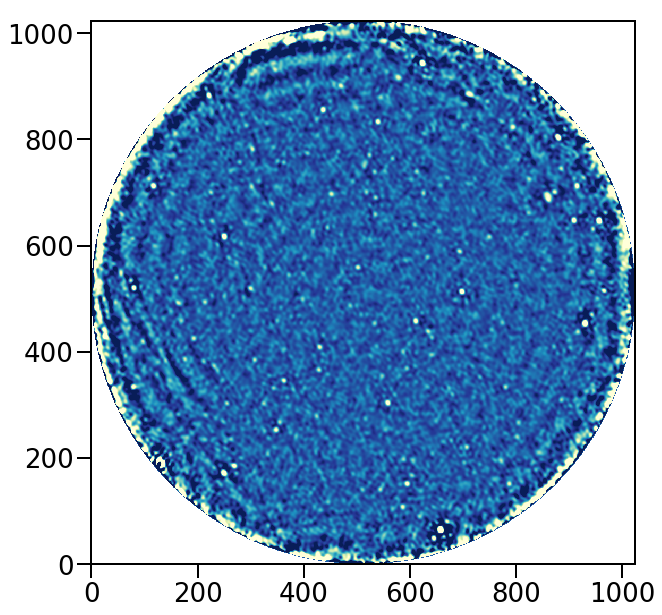

In [36]:
plt.figure(figsize=(10,10))
plt.imshow(img, origin="lower",vmin=-10,vmax=30, cmap="YlGnBu_r")
# plt.figure(figsize=(10,10))
# plt.imshow(data[0,0,:,:], origin="lower",vmin=-10,vmax=30, cmap="YlGnBu_r")

In [37]:
im_ra,im_decl,n,nn = wcs.wcs_pix2world(meshx,meshy,1,1,1)

In [38]:
c1 = SkyCoord(np.ravel(im_ra)*u.deg, np.ravel(im_decl)*u.deg, frame='fk5')
c2 = SkyCoord(aart.ra.values*u.deg, aart.decl.values*u.deg, frame='fk5')

radius = 3.

# idx, d2d, d3d = c1.match_to_catalog_sky(c2)
# idx, d2d, d3d = c1.separation(c2)

# Match measurements from observation to AARTFAAC cat

# idx, d2d, d3d = match_coordinates_sky(c1,c2)
idx1, idx2, sep2d, dist3d = search_around_sky(c1,c2,radius*u.deg)



# print c1[d2d.deg < radius]

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/astropy/coordinates/angles.py:651: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/astropy/coordinates/angles.py:651: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/astropy/coordinates/angles.py:534: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/astropy/coordinates/angles.py:534: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):


In [39]:
im_pix_x,im_pix_y,n,nn = wcs.wcs_world2pix(c1.ra[idx1],c1.dec[idx1],1,1,1)

In [224]:
#len(np.clip(im_pix_y+1,0,1023))

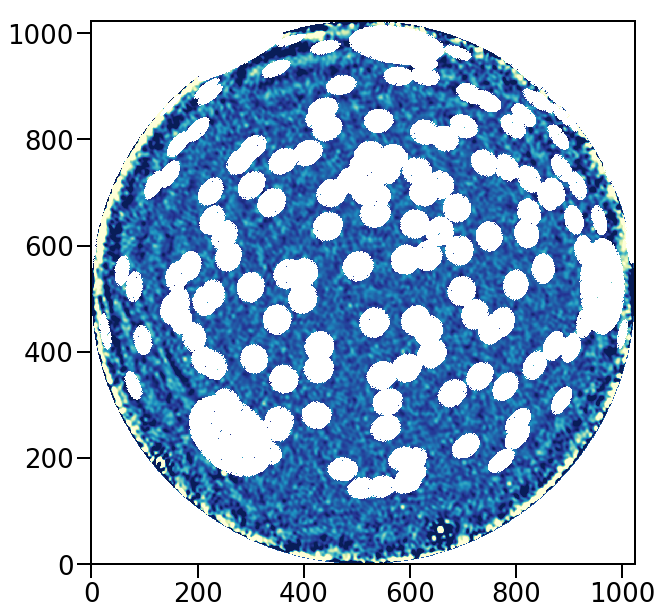

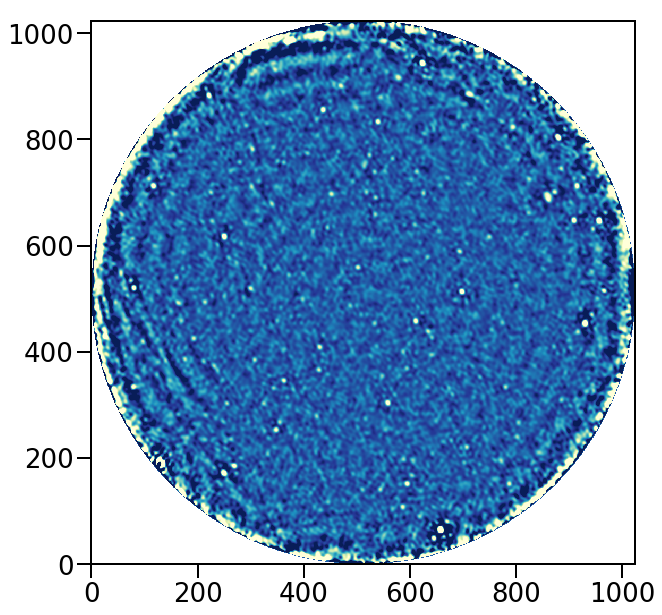

In [40]:
img = np.copy(data[0,0,:,:])

img[np.array(im_pix_y,dtype=int),
    np.array(im_pix_x,dtype=int)] = np.nan

img[np.array(np.clip(im_pix_y+1,0,1023),dtype=int),
    np.array(np.clip(im_pix_x+1,0,1023),dtype=int)] = np.nan

img[np.array(np.clip(im_pix_y-1,0,1023),dtype=int),
    np.array(np.clip(im_pix_x-1,0,1023),dtype=int)] = np.nan

img[np.array(np.clip(im_pix_y+2,0,1023),dtype=int),
    np.array(np.clip(im_pix_x+2,0,1023),dtype=int)] = np.nan

img[np.array(np.clip(im_pix_y-2,0,1023),dtype=int),
    np.array(np.clip(im_pix_x-2,0,1023),dtype=int)] = np.nan



radius = 10.

c3 = SkyCoord(ateam["ra"]*u.deg, ateam["decl"]*u.deg, frame='fk5')

idx1, idx2, sep2d, dist3d = search_around_sky(c1,c3,radius*u.deg)



im_pix_x,im_pix_y,n,nn = wcs.wcs_world2pix(c1.ra[idx1],c1.dec[idx1],1,1,1)

img[np.array(im_pix_y,dtype=int),
    np.array(im_pix_x,dtype=int)] = np.nan

img[np.array(np.clip(im_pix_y+1,0,1023),dtype=int),
    np.array(np.clip(im_pix_x+1,0,1023),dtype=int)] = np.nan

img[np.array(np.clip(im_pix_y-1,0,1023),dtype=int),
    np.array(np.clip(im_pix_x-1,0,1023),dtype=int)] = np.nan

img[np.array(np.clip(im_pix_y+2,0,1023),dtype=int),
    np.array(np.clip(im_pix_x+2,0,1023),dtype=int)] = np.nan

img[np.array(np.clip(im_pix_y-2,0,1023),dtype=int),
    np.array(np.clip(im_pix_x-2,0,1023),dtype=int)] = np.nan



plt.figure(figsize=(10,10))
plt.imshow(img, origin="lower",vmin=-10,vmax=30, cmap="YlGnBu_r")

plt.figure(figsize=(10,10))
plt.imshow(data[0,0,:,:], origin="lower",vmin=-10,vmax=30, cmap="YlGnBu_r")

running process


/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/sourcefinder/image.py:761: RuntimeWarning: invalid value encountered in greater
  (self.data_bgsubbed > analysisthresholdmap) &


IndexError: list index out of range

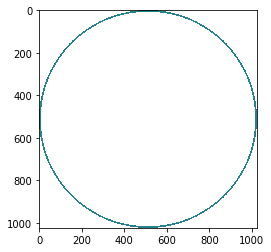

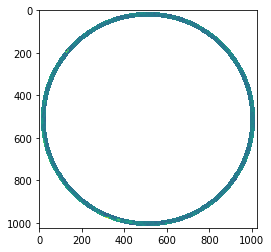

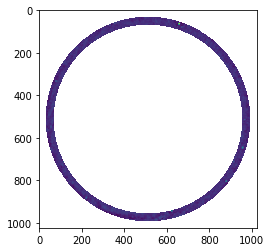

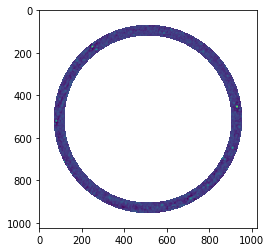

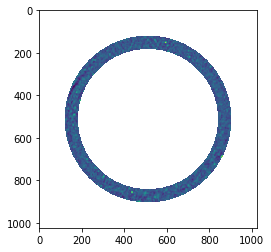

In [10]:
d90 = np.cos(np.radians(90))*512
d80 =  np.cos(np.radians(80))*512
d70 =  np.cos(np.radians(70))*512
d60 =  np.cos(np.radians(60))*512
d50 =  np.cos(np.radians(50))*512
d40 =  np.cos(np.radians(40))*512
d30 =  np.cos(np.radians(30))*512
d20 =  np.cos(np.radians(20))*512
d10 =  np.cos(np.radians(10))*512
d0 =  np.cos(np.radians(0))*512
zenith_angle = [d0,d10,d20,d30,d40,d50,d60,d70,d80,d90]
# zenith_angle = [d40,d50,d60,d70,d80,d90]
angles = [np.radians(40),np.radians(50),np.radians(60),np.radians(70),np.radians(80),np.radians(90)]

x, y = np.meshgrid(np.linspace(0,1024,1024),
                   np.linspace(0,1024,1024))

sensitivity = []
area = []

slope_cor, int_cor = process(image)

img = (img-int_cor)/slope_cor

mask = np.zeros((1024,1024), dtype=int)
for i in range(len(zenith_angle)-1):
    mask = np.zeros((1024,1024), dtype=int)
    mask[ np.where((np.sqrt((x-512)**2.+(y-512)**2.) <= zenith_angle[i]) &
                  (np.sqrt((x-512)**2.+(y-512)**2.) >= zenith_angle[i+1]))]+= 1


    canvas = np.nan*np.ones((1024,1024))
    canvas[np.array(mask, dtype=bool)] = img[np.array(mask, dtype=bool)]
    
#     print "STD in mask:\t\t", np.nanstd(canvas)
    sensitivity.append(8*np.nanstd(canvas))

    
#     print "search fraction:\t", np.float(len(np.where(np.isfinite(img[np.array(mask, dtype=bool)]))[0]))/ len(img[np.array(mask, dtype=bool)])
#     print "search area: \t\t",  np.float(len(np.where(np.isfinite(img[np.array(mask, dtype=bool)]))[0]))/ len(img[np.array(mask, dtype=bool)]) *(np.sin(angles[i+1])-np.sin(angles[i]))*2*np.pi * (180/np.pi)**2.
    area.append(np.float(len(np.where(np.isfinite(img[np.array(mask, dtype=bool)]))[0]))/ len(img[np.array(mask, dtype=bool)]) *(np.sin(angles[i+1])-np.sin(angles[i]))*2*np.pi * (180/np.pi)**2.)
    plt.figure()
    plt.imshow(canvas)
    
    

<IPython.core.display.Javascript object>


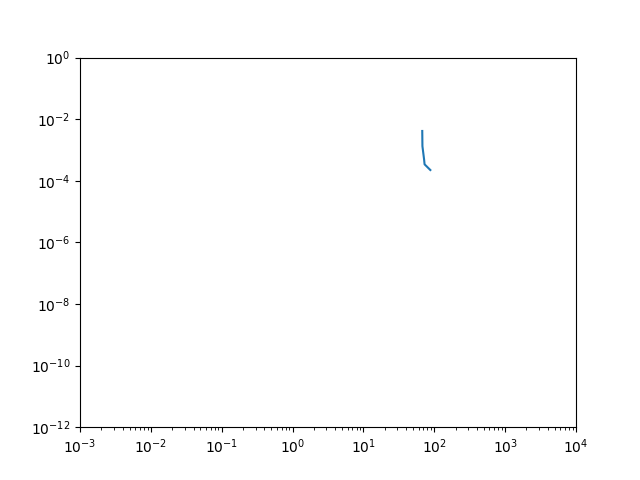

(1e-12, 1.0)

In [30]:
%matplotlib notebook

area_sum = []

idx = np.argsort(sensitivity)
area_sum.append(np.array(area)[idx][0])

for i in range(len(area)-1):
#     idx = np.argsort(sensitivity)
    area_sum.append(np.sum(np.array(area)[idx][:i+2]))

plt.plot(np.array(sensitivity)[idx],1./(1*np.array(area_sum)))
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-3,1e4])
plt.ylim([1e-12,1e0])


In [31]:
print np.array(area)[idx]
for i in range(len(area)-1):
    print np.array(area)[idx][:i+2]

[  241.16382761   510.06159032  1286.17991074   880.32295621  1551.52806398]
[ 241.16382761  510.06159032]
[  241.16382761   510.06159032  1286.17991074]
[  241.16382761   510.06159032  1286.17991074   880.32295621]
[  241.16382761   510.06159032  1286.17991074   880.32295621  1551.52806398]


In [32]:
img_result = pd.DataFrame({"sensitivity":np.array(sensitivity)[idx], "area_sum":area_sum})


In [33]:
previous_result = pd.read_csv("/home/kuiack/AARTFAACsurvey_sensitivity_plot.csv")

total_result = pd.concat([img_result,previous_result])
total_result.to_csv("/home/kuiack/totsensitivity_plot.csv", index=False)

In [205]:
#img_result.to_csv("/home/kuiack/sensitivity_plot.csv", index=False)

In [12]:
tot_survey = pd.read_csv("/home/kuiack/AARTFAACsurvey_sensitivity_plot.csv")


In [13]:




area_sum = []

idx = np.argsort(tot_survey["sensitivity"])
area_sum.append(tot_survey["area"].iloc[idx].values[0])

for i in range(len(tot_survey["area"])-1):
    area_sum.append(np.sum((tot_survey["area"].iloc[idx]).values[:i+2]))

In [13]:
print tot_survey["area"].iloc[idx].values[0]
i=0
print (tot_survey["area"].iloc[idx]).values[:i+2]
i=1
print (tot_survey["area"].iloc[idx]).values[:i+2]

241.631419795
[ 241.63141979  205.95540002]
[ 241.63141979  205.95540002  241.23965337]


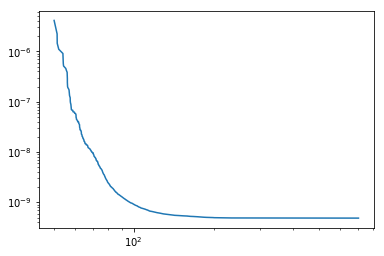

In [15]:
plt.plot(8*tot_survey["sensitivity"].loc[idx], 1./(1000*np.array(area_sum)))
plt.xscale("log")
plt.yscale("log")

In [10]:
sorted_sensitivity = tot_survey["sensitivity"].reshape((len(tot_survey["sensitivity"])/5,5))

/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


In [10]:
idx = np.argsort(tot_survey["sensitivity"])
print idx

0        134
1         84
2        739
3        674
4        639
5        703
6        139
7        714
8        284
9        129
10       737
11       638
12       177
13       179
14       174
15      1539
16       704
17       132
18       738
19      1369
20       637
21       702
22      1538
23       137
24      1559
25       138
26      1536
27        83
28       178
29       164
        ... 
2060     147
2061     995
2062    2040
2063      95
2064    1150
2065    1035
2066     620
2067     625
2068     651
2069     916
2070     605
2071     753
2072     705
2073     752
2074     656
2075     751
2076     937
2077     157
2078     915
2079     600
2080     750
2081     687
2082     587
2083     774
2084     378
2085     773
2086     772
2087     771
2088     770
2089    1697
Name: sensitivity, Length: 2090, dtype: int64


In [16]:
np.imshow(sorted_sensitivity[idx][:,:,0], aspect=)

(418, 5)

/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


TypeError: Invalid dimensions for image data

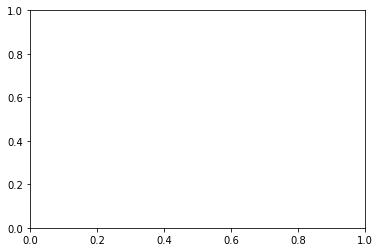

In [21]:
plt.imshow(tot_survey["sensitivity"].reshape((len(tot_survey["sensitivity"])/5,5))[idx], aspect="auto")

In [11]:
tot_survey = pd.read_csv("AARTFAACsurvey_sensitivity_plot.csv")

tot_area_sum = []

idx = np.argsort(tot_survey["sensitivity"])
tot_area_sum.append(np.array(tot_survey["area_sum"])[idx][0])
plt.figure()
for i in range(len(tot_survey["area_sum"])-1):
#     idx = np.argsort(sensitivity)
    tot_area_sum.append(np.sum(np.array(tot_survey["area_sum"])[idx][:i+2]))

plt.plot(np.array(tot_survey["sensitivity"])[idx],1./(np.array(tot_area_sum)))
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-3,1e4])
plt.ylim([1e-12,1e0])


IOError: File AARTFAACsurvey_sensitivity_plot.csv does not exist

In [20]:
std_map = np.std(rolling_window(img, 
                                window=(5,5)),axis=(2,3))
mean_map = np.mean(rolling_window(img, 
                                  window=(5,5)),axis=(2,3))# , vmin=-10,vmax=30, cmap="YlGnBu_r")

In [24]:
np.nanmean(std_map)

8.0213966

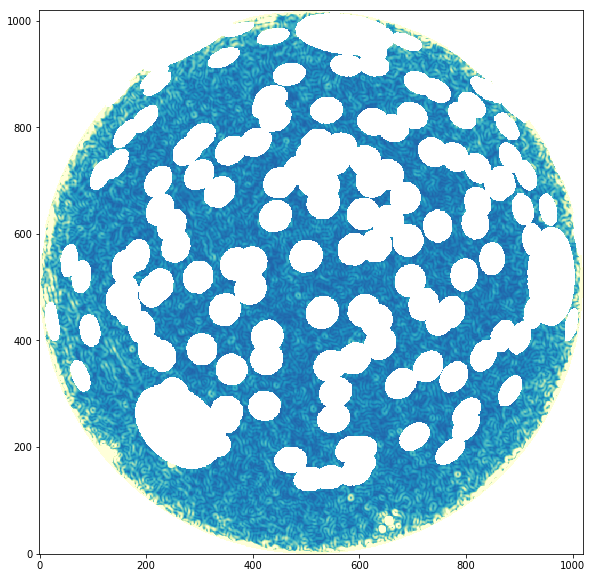

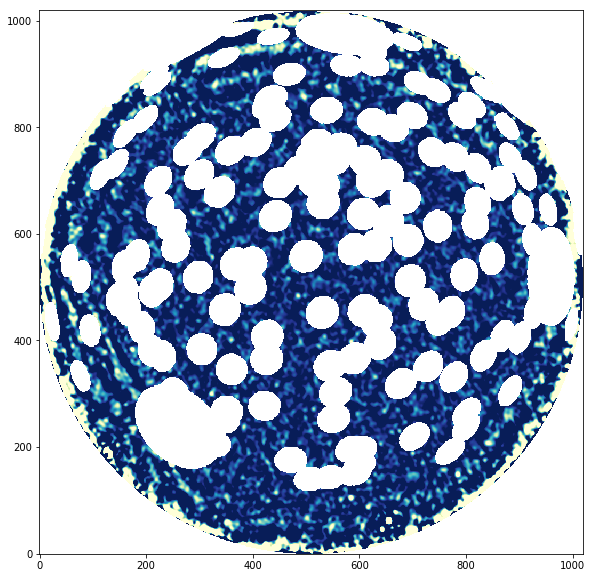

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(std_map, origin="lower",vmin=-10,vmax=30, cmap="YlGnBu_r")
plt.figure(figsize=(10,10))
plt.imshow(mean_map, origin="lower",vmin=-10,vmax=30, cmap="YlGnBu_r")

In [112]:
canvas = np.nan*np.ones((1024,1024))
canvas[np.array(mask, dtype=bool)] = img[np.array(mask, dtype=bool)]
np.nanstd(canvas)

5.2025191652461213

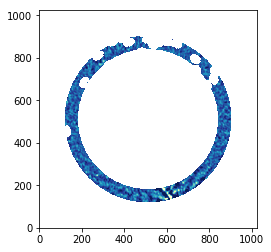

In [111]:
plt.imshow(canvas, origin="lower", vmin=-10,vmax=30, cmap="YlGnBu_r")

In [133]:
# area in square degrees in annulus
angles = [np.radians(90),np.radians(80),np.radians(70),np.radians(60),np.radians(50),np.radians(40)]

for i in range(len(angles)-1):
    print (np.sin(angles[i])-np.sin(angles[i+1]))*2*np.pi * (180/np.pi)**2.

313.362588139
930.566400747
1519.49542416
2062.25534801
2542.35468666


In [132]:
# test equation, total sphere = 41252.96 square degrees

(np.sin(np.radians(90))-np.sin(np.radians(-90)))*2*np.pi * (180/np.pi)**2.

41252.961249419277

18837.0

running process


(0.24681290956417282, 2.7608942911787979)

In [7]:
"""
functions for calculating statistical properties of LOFAR images
"""


def rms(data):
    """Returns the RMS of the data about the median.
    Args:
        data: a numpy array
    """
    data -= numpy.median(data)
    return numpy.sqrt(numpy.power(data, 2).sum()/len(data))


def clip(data, sigma=3):
    """Remove all values above a threshold from the array.
    Uses iterative clipping at sigma value until nothing more is getting clipped.
    Args:
        data: a numpy array
    """
    raveled = data.ravel()
    median = numpy.median(raveled)
    std = numpy.std(raveled)
    newdata = raveled[numpy.abs(raveled-median) <= sigma*std]
    if len(newdata) and len(newdata) != len(raveled):
        return clip(newdata, sigma)
    else:
        return newdata


def subregion(data, f=4):
    """Returns the inner region of a image, according to f.
    Resulting area is 4/(f*f) of the original.
    Args:
        data: a numpy array
    """
    x, y = data.shape
    return data[(int(x/2) - int(x/f)):(int(x/2) + int(x/f)), (int(y/2) - int(y/f)):(int(y/2) + int(y/f))]


def rms_with_clipped_subregion(data, sigma=3, f=4):
    """ returns the rms value of a iterative sigma clipped subsection of an image
    Args:
        data: A numpy array
        sigma: sigma value used for clipping
        f: determines size of subsection, result will be 1/fth of the image size
    """
    return rms(clip(subregion(data, f), sigma))

def read_data(hdu, plane):
    """
    Read and store data from our FITS file.
    NOTE: PyFITS reads the data into an array indexed as [y][x]. We
    take the transpose to make this more intuitively reasonable and
    consistent with (eg) ds9 display of the FitsFile. Transpose back
    before viewing the array with RO.DS9, saving to a FITS file,
    etc.
    """
    data = numpy.float64(hdu.data.squeeze())
    if plane is not None and len(data.shape) > 2:
        data = data[plane].squeeze()
    n_dim = len(data.shape)
    if n_dim != 2:
        #logger.warn("Loaded datacube with %s dimensions, assuming Stokes I and taking plane 0" % n_dim)
        data = data[0, :, :]
    data = data.transpose()
    return data

In [8]:
#!/usr/bin/python
#
#
# Author: Antonia Rowlinson
# E-mail: b.a.rowlinson@uva.nl
#


matplotlib.rcParams.update({'font.size': 24})
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['xtick.major.size'] = 14
matplotlib.rcParams['ytick.major.size'] = 14
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.width'] = 2

def read_datafile(filename):
    info=[]
    data=open(filename,'r')
    for lines in data:
        if not lines.startswith('#'):
            lines=lines.rstrip()
            src_data=lines.split(',')
            info.append(src_data)
    data.close()
    return info


def plotfig_rates2(trans_data, a, b, xlabel, ylabel, plotname,trackAvg):#,sumImgs):
    plt.clf()
    plt.close()
    fig = plt.figure(1,figsize=(40,20))
    matplotlib.rcParams.update({'font.size': 40})
    matplotlib.rcParams.update({'axes.linewidth' : 5})

    #labels=np.unique([x[4] for x in trans_data])
    labels=['AARTFAAC 1s','AARTFAAC 10min','Rowlinson et al. (2016)','Stewart et al. (2016)','Obenberger et al. (2015)','Bell et al. (2014)','Carbone et al. (2014)','Cendes et al. (2014)','Jaeger et al. (2012)','Bannister et al. (2011)','Lazio et al. (2010)','Hyman et al. (2009)']

    pltlabels=['AARTFAAC 1s','AARTFAAC 10min','Rowlinson et al. (2016)','Stewart et al. (2016)','Obenberger et al. (2015)','Bell et al. (2014)','Carbone et al. (2014)','Cendes et al. (2014)','Jaeger et al. (2012)','Bannister et al. (2011)','Lazio et al. (2010)','Hyman et al. (2009)']

    
    markers=['o','*','s','D','v','8','^','s','<','*','>','p']
    c=matplotlib.cm.rainbow_r(np.linspace(0,1,12))
    #c=[next(color) for a in range(10)]
    #plt.plot(x,y,c=c)
    
    pylab.subplots_adjust(wspace=0.001)
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, sharey=ax1)

    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0 + box.height * 0.15,box.width, box.height * 0.9])
    box = ax2.get_position()
    ax2.set_position([box.x0, box.y0 + box.height * 0.15,box.width, box.height * 0.9])
    
    for a in range(len(labels)):
        if labels[a] in pltlabels:
            ax2.plot([trans_data[x][0] for x in range(len(trans_data)) if trans_data[x][4]==labels[a]],[trans_data[x][1] for x in range(len(trans_data)) if trans_data[x][4]==labels[a]],linewidth=4, marker=markers[a],markersize=24,c=c[a],label=labels[a],ls='none')
            ax2.quiver([trans_data[x][0] for x in range(len(trans_data)) if trans_data[x][4]==labels[a] if trans_data[x][3]=='0'],[trans_data[x][1] for x in range(len(trans_data)) if trans_data[x][4]==labels[a] if trans_data[x][3]=='0'],0,-20)
            ax1.plot([trans_data[x][2] for x in range(len(trans_data)) if trans_data[x][4]==labels[a]],[trans_data[x][1] for x in range(len(trans_data)) if trans_data[x][4]==labels[a]],linewidth=4,marker=markers[a],markersize=24,c=c[a],label=labels[a],ls='none')
            ax1.quiver([trans_data[x][2] for x in range(len(trans_data)) if trans_data[x][4]==labels[a] if trans_data[x][3]=='0'],[trans_data[x][1] for x in range(len(trans_data)) if trans_data[x][4]==labels[a] if trans_data[x][3]=='0'],0,-20)

#plot a -3/2 line from Stewart et al. rate at ~10 min
    xtmp = np.logspace(-3.3,5,50)
    ytmp = [0.000333*(a**(-3./2.)) for a in xtmp]
    ax2.plot(xtmp,ytmp,'k-',linewidth=4)

#    for x in range(len(trans_data)):
#        if trans_data[x][4]=="This Work" and trans_data[x][4] in pltlabels:
#            C=0.162
#            ax2.plot([0.162*np.exp(float(r+2)**2. / 255.38) for r in range(11)],[((12./float(r+2))**2.)*trans_data[x][1] for r in range(11)],'r-',linewidth=4)
#            break
#    v= [a[0] for a in sumImgs]
#    w= [a[1] for a in sumImgs]
#    print(sumImgs)
#    minw= min(w)
#    ax2.plot(max(v),min(w),'b*',markersize=24)
#    ax1.plot(1./(24.*60.*60.),min(w),'b*',markersize=24)
#    ax2.plot(v,w,'b-',linewidth=4)
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim([5e-4,1e5])
    ax1.set_xlim([5e-6,3e3])
    ax1.set_ylim([2e-12,1])
    ax2.set_xlabel('Sensitivity (Jy)')
    ax1.set_xlabel('Timescale (days)')
    ax1.set_ylabel(r'Surface density (deg$^{-2}$)')
    yticklabels = ax2.get_yticklabels()
    pylab.setp(yticklabels,visible=False)
    ax1.axvline(x=1.157e-5, linewidth=4, color='k', linestyle='--')
    ax1.text(1.157e-5*1.2,1e-9,'1 second',rotation=90)
    ax1.axvline(x=6.944e-4, linewidth=4, color='k', linestyle='--')
    ax1.text(6.944e-4*1.2,1e-9,'1 minute',rotation=90)
    ax1.axvline(x=0.041667, linewidth=4, color='k', linestyle='--')
    ax1.text(0.041667*1.2,1e-9,'1 hour',rotation=90)
    ax1.axvline(x=1, linewidth=4, color='k', linestyle='--')
    ax1.text(1*1.2,1e-9,'1 day',rotation=90)
    ax1.axvline(x=30, linewidth=4, color='k', linestyle='--')
    ax1.text(30*1.2,1e-9,'1 month',rotation=90)
    ax1.axvline(x=365, linewidth=4, color='k', linestyle='--')
    ax1.text(365*1.2,1e-9,'1 year',rotation=90)
    ax1.tick_params(axis='x', pad=20)
    ax2.tick_params(axis='x', pad=20)
    ax1.tick_params(axis='y', pad=20)
    ax2.tick_params(axis='y', pad=20)
    ax1.legend(bbox_to_anchor=(-0.15, -0.27), loc='lower left', borderaxespad=0.,numpoints=1, fontsize = 'small', ncol=5)
#     plt.savefig(plotname+'.png')
    plt.close(fig)
    matplotlib.rcParams.update({'font.size': 26})
    matplotlib.rcParams.update({'axes.linewidth' : 2})
    plt.show()

def getImageInfo(dataPath,sigmaClip,f):
    imageData=[]
    if not os.path.isfile('rmsData.csv'):
        outfile=open('rmsData.csv','w')
        outfile.write('#file,rms,date\n')
        for filename in sorted(glob.glob(dataPath+'*.fits')):
            hdu=0
            data = getRMS.read_data(pyfits.open(filename)[hdu], plane=None)
            hdulist=pyfits.open(filename)
            prihdr=hdulist[0].header
            obsrms=getRMS.rms_with_clipped_subregion(data, sigmaClip, f)
            date=prihdr['DATE-OBS']
            imageData.append([filename, obsrms,date])
            outfile.write(filename+','+str(obsrms)+','+str(date)+'\n')
        outfile.close()
    else:
        imageData=read_datafile('rmsData.csv')
    return imageData

def scaleBeam(RMS,imgRMS,detectThresh,HWHM,imgRadius):
    # A clever way of using the beam model to figure out how much area is enclosed up to the RMS that we're interested in...
    q = np.log(RMS/imgRMS) #RMS is the array of RMS values, imgRMS is the RMS measured in the small central area of the image, you don't want it to be negative bc that would mean no area
    if q < 0:
        return 0
    else:
        r= HWHM*np.sqrt(2.*q)
        if r > imgRadius:
            r = imgRadius
        areas = 2.*np.pi*r**2.
        return areas

def getAreasEnclosed(RMSrange,imageRMS,detectThresh,HWHM,imgRadius):
    areaVals=[]
    for RMSval in RMSrange:
        areaEnclosed=scaleBeam(RMSval,imageRMS,detectThresh,HWHM,imgRadius)
        areaVals.append([RMSval,areaEnclosed])
    return areaVals

In [9]:



ratesData = read_datafile('/home/kuiack/AARTFAAC_2018/ratesData2.csv')
TMPdata=[[float(x[0]), float(x[1]), float(x[2]), x[3], x[4]] for x in ratesData]

plotfig_rates2(TMPdata,0,1, 'Limiting Flux Density (Jy)', r'Surface density (deg$^{-2}$)', 'rates_AARTFAAC',False)#,sumImgs2)

plt.show()


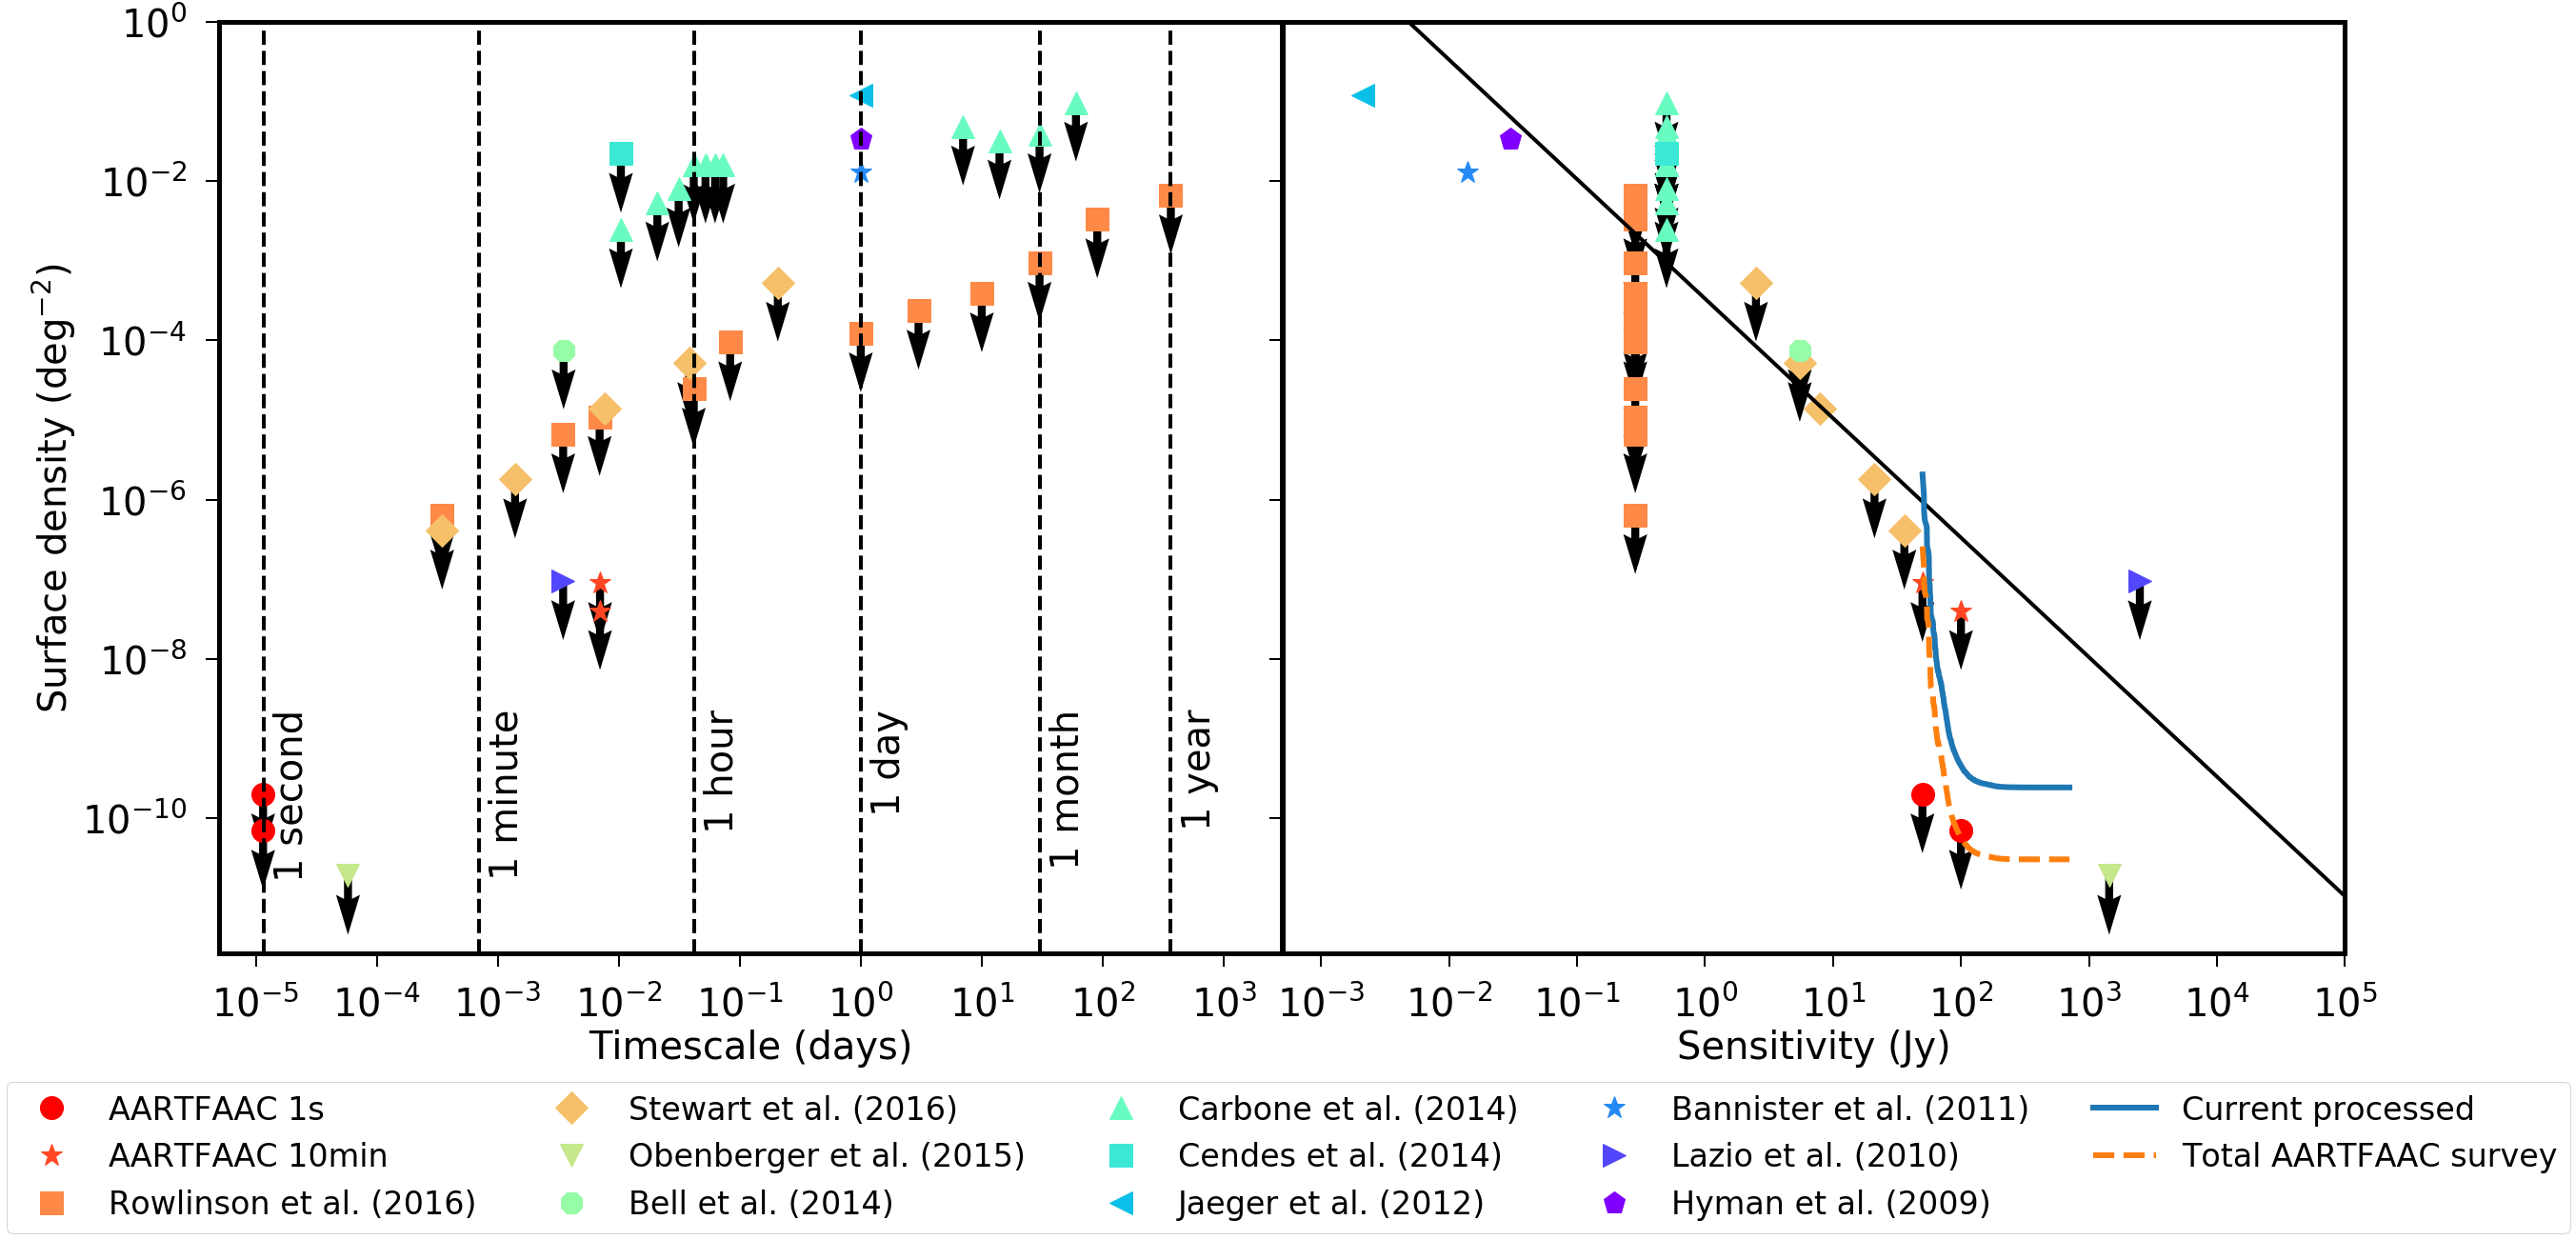

In [14]:
ratesData = read_datafile('/home/kuiack/AARTFAAC_2018/ratesData2.csv')
TMPdata=[[float(x[0]), float(x[1]), float(x[2]), x[3], x[4]] for x in ratesData]

trans_data = TMPdata
a = 0
b = 1 
xlabel = 'Limiting Flux Density (Jy)'
ylabel = r'Surface density (deg$^{-2}$)'
plotname = 'rates_AARTFAAC'
trackAvg = False



fig = plt.figure(1,figsize=(40,20))
matplotlib.rcParams.update({'font.size': 40})
matplotlib.rcParams.update({'axes.linewidth' : 5})

#labels=np.unique([x[4] for x in trans_data])
labels=['AARTFAAC 1s','AARTFAAC 10min','Rowlinson et al. (2016)','Stewart et al. (2016)','Obenberger et al. (2015)','Bell et al. (2014)','Carbone et al. (2014)','Cendes et al. (2014)','Jaeger et al. (2012)','Bannister et al. (2011)','Lazio et al. (2010)','Hyman et al. (2009)']

pltlabels=['AARTFAAC 1s','AARTFAAC 10min','Rowlinson et al. (2016)','Stewart et al. (2016)','Obenberger et al. (2015)','Bell et al. (2014)','Carbone et al. (2014)','Cendes et al. (2014)','Jaeger et al. (2012)','Bannister et al. (2011)','Lazio et al. (2010)','Hyman et al. (2009)']


markers=['o','*','s','D','v','8','^','s','<','*','>','p']
c=matplotlib.cm.rainbow_r(np.linspace(0,1,12))
#c=[next(color) for a in range(10)]
#plt.plot(x,y,c=c)

pylab.subplots_adjust(wspace=0.001)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharey=ax1)

box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * 0.15,box.width, box.height * 0.9])
box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + box.height * 0.15,box.width, box.height * 0.9])

for a in range(len(labels)):
    if labels[a] in pltlabels:
        ax2.plot([trans_data[x][0] for x in range(len(trans_data)) if trans_data[x][4]==labels[a]],[trans_data[x][1] for x in range(len(trans_data)) if trans_data[x][4]==labels[a]],linewidth=4, marker=markers[a],markersize=24,c=c[a],label=labels[a],ls='none')
        ax2.quiver([trans_data[x][0] for x in range(len(trans_data)) if trans_data[x][4]==labels[a] if trans_data[x][3]=='0'],[trans_data[x][1] for x in range(len(trans_data)) if trans_data[x][4]==labels[a] if trans_data[x][3]=='0'],0,-20)
        ax1.plot([trans_data[x][2] for x in range(len(trans_data)) if trans_data[x][4]==labels[a]],[trans_data[x][1] for x in range(len(trans_data)) if trans_data[x][4]==labels[a]],linewidth=4,marker=markers[a],markersize=24,c=c[a],label=labels[a],ls='none')
        ax1.quiver([trans_data[x][2] for x in range(len(trans_data)) if trans_data[x][4]==labels[a] if trans_data[x][3]=='0'],[trans_data[x][1] for x in range(len(trans_data)) if trans_data[x][4]==labels[a] if trans_data[x][3]=='0'],0,-20)

#plot a -3/2 line from Stewart et al. rate at ~10 min
xtmp = np.logspace(-3.3,5,50)
ytmp = [0.000333*(a**(-3./2.)) for a in xtmp]
ax2.plot(xtmp,ytmp,'k-',linewidth=4)

#every 1000th image, 2 subbands
ax2.plot(8*np.array(tot_survey["sensitivity"])[idx],
         1./(2*1000.*np.array(area_sum)),linewidth=6, label="Current processed")
#100 houra processed, 800 in total
ax2.plot(8*np.array(tot_survey["sensitivity"])[idx],
         1./(2*8000.*np.array(area_sum)), "--",linewidth=6,label="Total AARTFAAC survey")

ax1.plot(np.min(8*np.array(tot_survey["sensitivity"])[idx]),
         1,linewidth=6, label="Current processed")
ax1.plot(np.min(8*np.array(tot_survey["sensitivity"])[idx]),
         1, "--",linewidth=6,label="Total AARTFAAC survey")


#    for x in range(len(trans_data)):
#        if trans_data[x][4]=="This Work" and trans_data[x][4] in pltlabels:
#            C=0.162
#            ax2.plot([0.162*np.exp(float(r+2)**2. / 255.38) for r in range(11)],[((12./float(r+2))**2.)*trans_data[x][1] for r in range(11)],'r-',linewidth=4)
#            break
#    v= [a[0] for a in sumImgs]
#    w= [a[1] for a in sumImgs]
#    print(sumImgs)
#    minw= min(w)
#    ax2.plot(max(v),min(w),'b*',markersize=24)
#    ax1.plot(1./(24.*60.*60.),min(w),'b*',markersize=24)
#    ax2.plot(v,w,'b-',linewidth=4)
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')
ax2.set_xlim([5e-4,1e5])
ax1.set_xlim([5e-6,3e3])
ax1.set_ylim([2e-12,1])
ax2.set_xlabel('Sensitivity (Jy)')
ax1.set_xlabel('Timescale (days)')
ax1.set_ylabel(r'Surface density (deg$^{-2}$)')
yticklabels = ax2.get_yticklabels()
pylab.setp(yticklabels,visible=False)
ax1.axvline(x=1.157e-5, linewidth=4, color='k', linestyle='--')
ax1.text(1.157e-5*1.2,1e-9,'1 second',rotation=90)
ax1.axvline(x=6.944e-4, linewidth=4, color='k', linestyle='--')
ax1.text(6.944e-4*1.2,1e-9,'1 minute',rotation=90)
ax1.axvline(x=0.041667, linewidth=4, color='k', linestyle='--')
ax1.text(0.041667*1.2,1e-9,'1 hour',rotation=90)
ax1.axvline(x=1, linewidth=4, color='k', linestyle='--')
ax1.text(1*1.2,1e-9,'1 day',rotation=90)
ax1.axvline(x=30, linewidth=4, color='k', linestyle='--')
ax1.text(30*1.2,1e-9,'1 month',rotation=90)
ax1.axvline(x=365, linewidth=4, color='k', linestyle='--')
ax1.text(365*1.2,1e-9,'1 year',rotation=90)
ax1.tick_params(axis='x', pad=20)
ax2.tick_params(axis='x', pad=20)
ax1.tick_params(axis='y', pad=20)
ax2.tick_params(axis='y', pad=20)
ax1.legend(bbox_to_anchor=(-0.2, -0.30), 
           loc='lower left', borderaxespad=0.,numpoints=1, fontsize = 'small', ncol=5)
#     plt.savefig(plotname+'.png')

matplotlib.rcParams.update({'font.size': 26})
matplotlib.rcParams.update({'axes.linewidth' : 2})

plt.show()


In [26]:
len(tot_survey["sensitivity"])/5 

13

In [29]:
402139/5

80427

In [33]:
os.path.isfile("/home/kuiack/totsensitivity_plot.csv") 

True